In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import glob
from PIL import Image
import cv2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Dataset taken from:
https://www.kaggle.com/ankitesh97/pokemon-images/version/1

In [2]:
mnist = pd.read_csv('fashionmnist/fashion-mnist_test.csv')
mnist.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data = mnist.iloc[:, 1:].values.reshape(-1, 28, 28)
print(data.shape)
dataset_size = data.shape[0]
width = data.shape[1]
height = data.shape[2]

(10000, 28, 28)


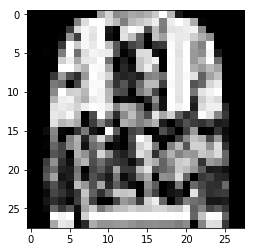

In [4]:
plt.imshow(data[3], cmap='gray')
plt.show()

In [18]:
def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()

    im = [OffsetImage(i, zoom=zoom, cmap='gray') for i in images]
    x, y = np.atleast_1d(x, y)
    artists = []
    
    for x0, y0, i in zip(x, y, im):
        ab = AnnotationBbox(i, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [6]:
def plot_random(x, y, images, n, zoom):
    size = len(images)
    
    indices = np.random.choice(np.arange(size), n, replace=False)
    x_sample = x[indices]
    y_sample = y[indices]
    img_sample = images[indices]
    
    return imscatter(x_sample, y_sample, img_sample, zoom=zoom)

<IPython.core.display.Javascript object>


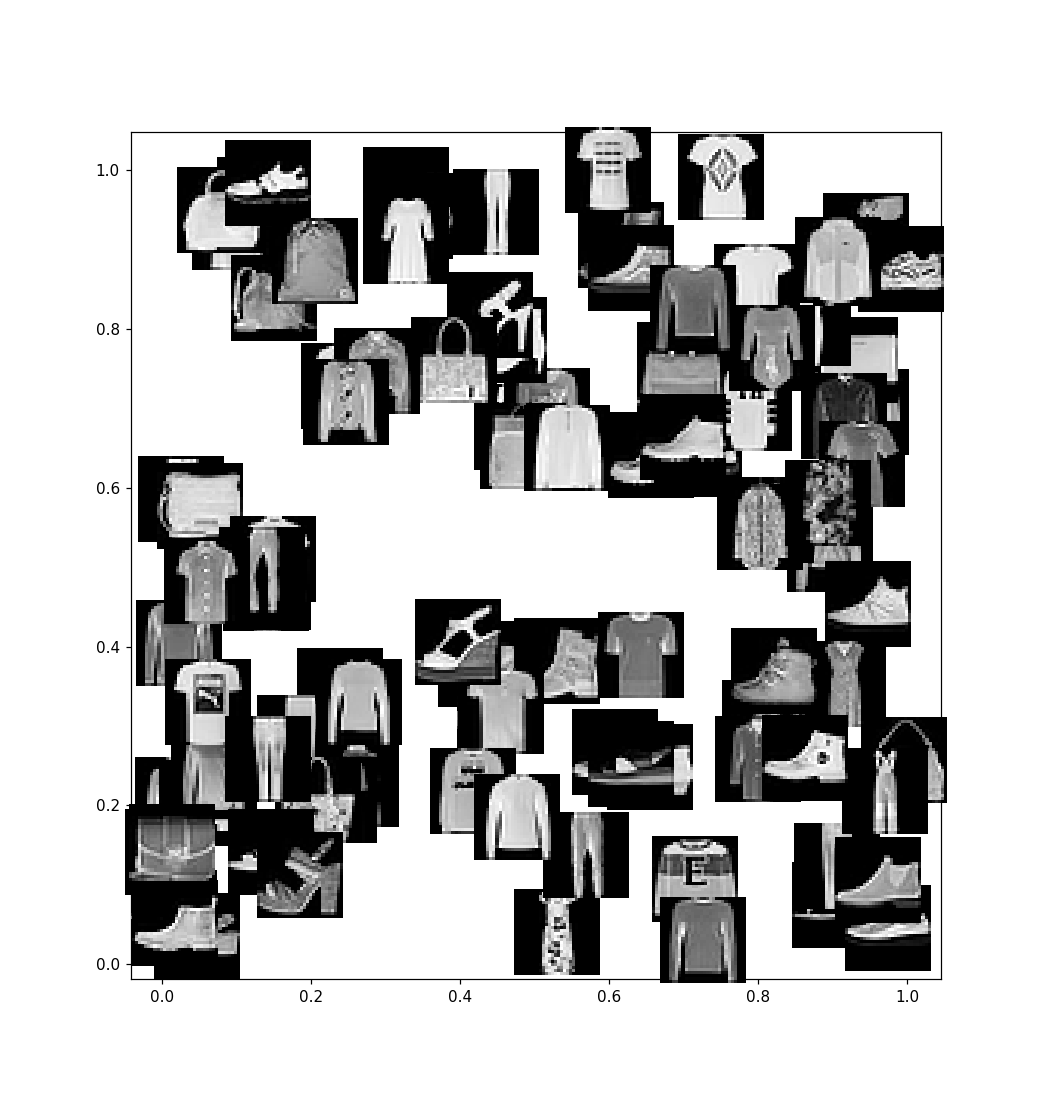

In [19]:
plt.figure(figsize=(9.5, 10))
fig = plot_random(
    np.random.rand(dataset_size),
    np.random.rand(dataset_size),
    data[:dataset_size],
    100,
    zoom=2)
plt.show()

In [12]:
flat_data = data.reshape(-1, width*height)
scaled_data = StandardScaler().fit_transform(flat_data)

scaled_data.shape

/home/mateusz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/mateusz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(10000, 784)

In [14]:
pca = PCA(n_components=2)
comp = pca.fit_transform(scaled_data)
comp_df = pd.DataFrame(data=comp)
comp_df.head()

,0,1
0,15.896960,-4.208240
1,-1.146555,-17.445201
2,-9.792420,-3.207340
3,10.415549,2.468585
4,2.907731,-10.894793


<IPython.core.display.Javascript object>


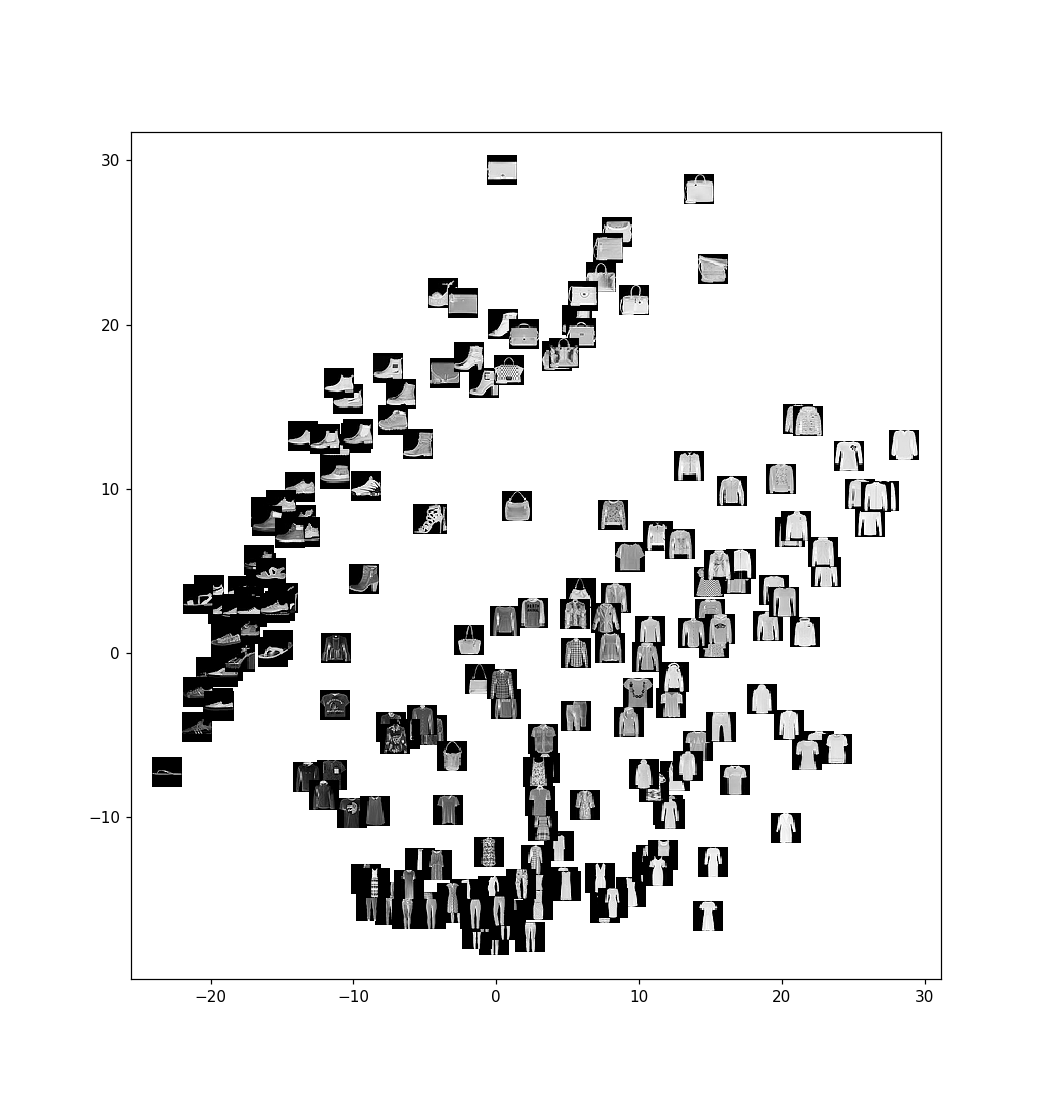

In [21]:
%matplotlib notebook
plt.figure(figsize=(9.5, 10))
fig = plot_random(
    comp_df[0],
    comp_df[1],
    data,
    200,
    zoom=0.7)

In [24]:
kpca = KernelPCA(n_components=2, kernel='rbf')
comp = kpca.fit_transform(scaled_data)
comp_df = pd.DataFrame(data=comp)
comp_df.head()

,0,1
0,-0.354244,0.017799
1,-0.073305,-0.490516
2,0.278615,-0.102473
3,-0.092579,0.168733
4,-0.124392,-0.183782


<IPython.core.display.Javascript object>


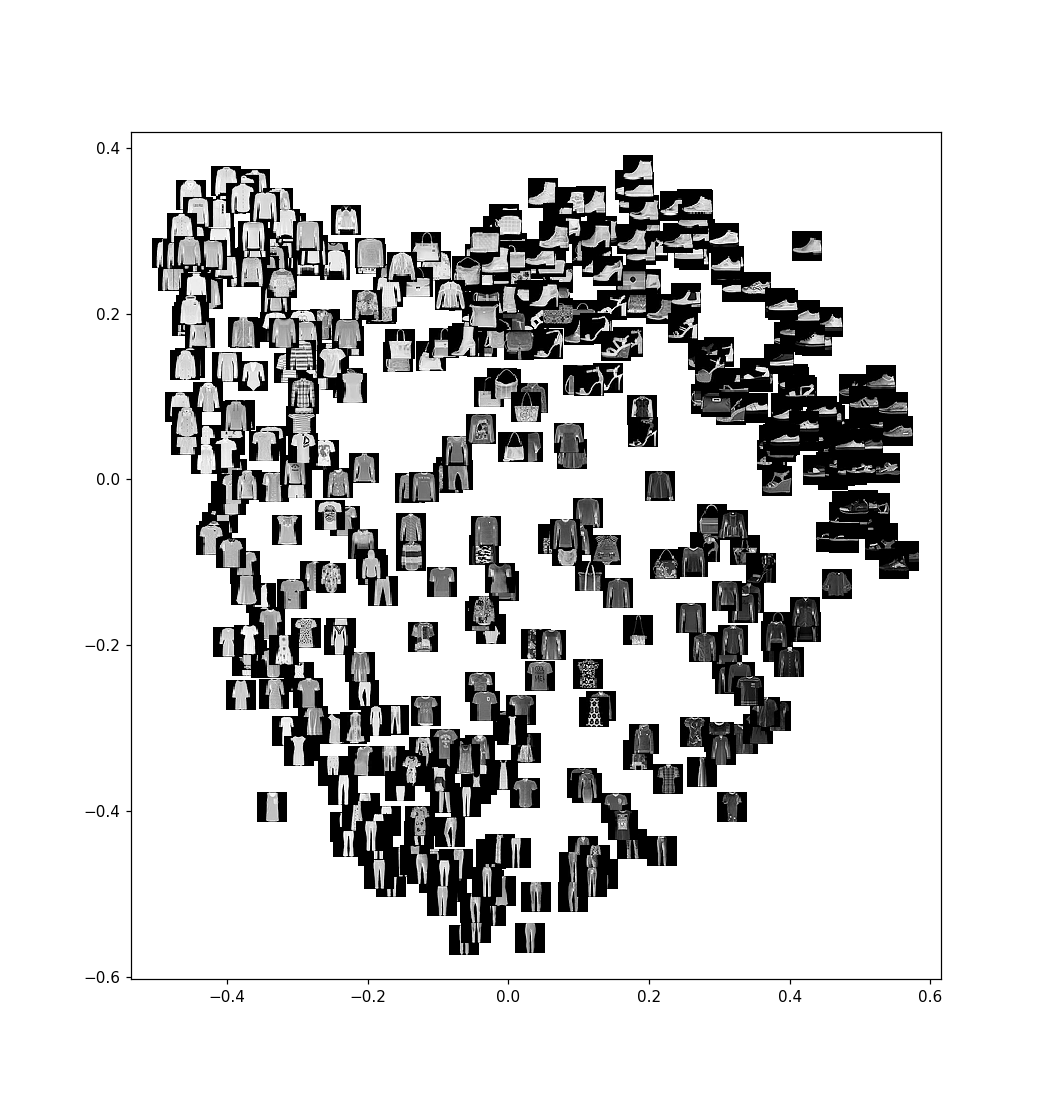

In [33]:
%matplotlib notebook
plt.figure(figsize=(9.5, 10))
fig = plot_random(
    comp_df[0],
    comp_df[1],
    data,
    500,
    zoom=0.7)

In [165]:
kpca = KernelPCA(n_components=2, kernel='rbf')
comp = kpca.fit_transform(scaled_edges)
comp_df = pd.DataFrame(data=comp, columns=['pc1', 'pc2'])
comp_df.head()

,pc1,pc2
0,-0.009310,0.093325
1,-0.018633,0.042961
2,0.078798,0.049105
3,-0.071694,0.052726
4,-0.054769,0.026893


<IPython.core.display.Javascript object>


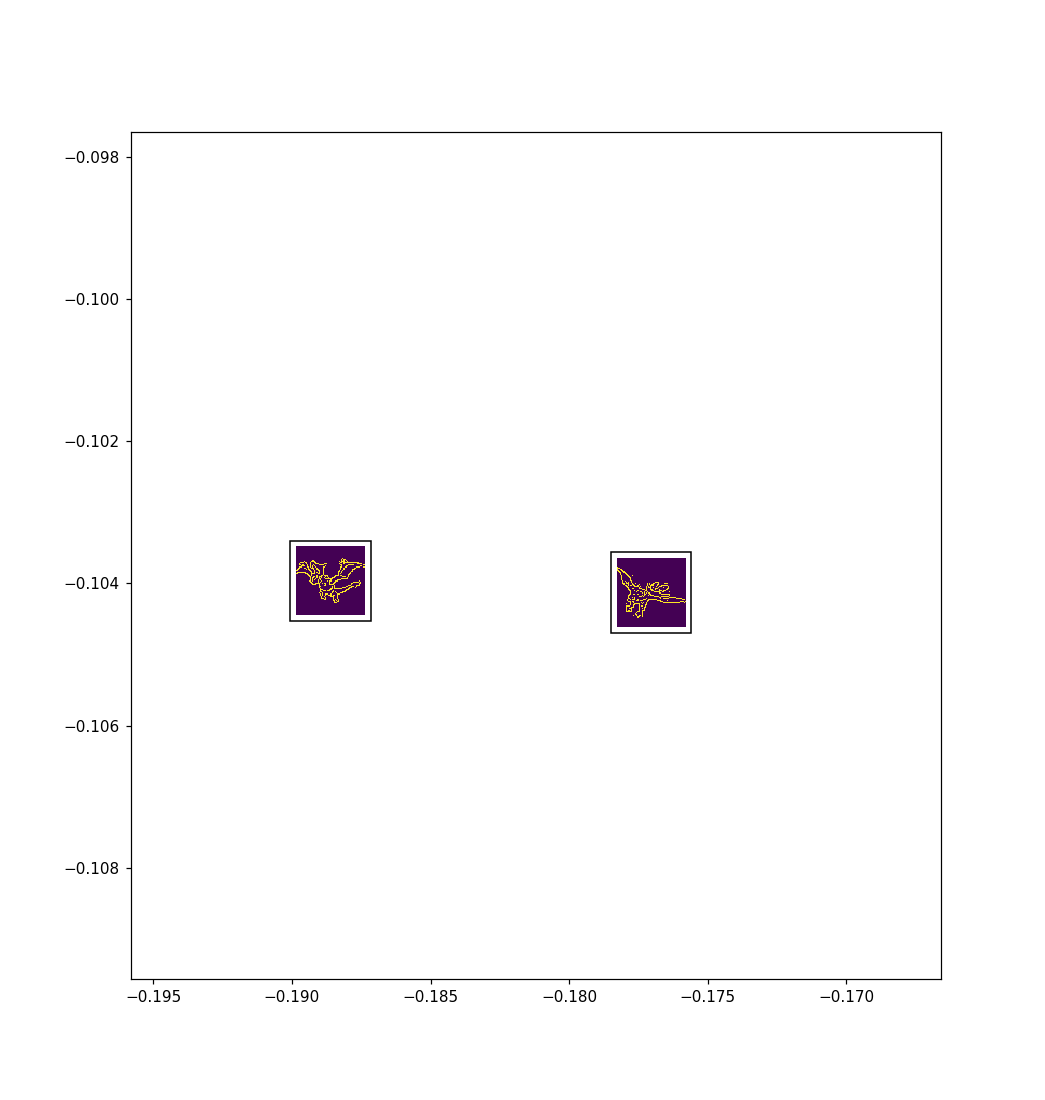

In [181]:
%matplotlib notebook
plt.figure(figsize=(9.5, 10))
fig = plot_random(
    comp_df['pc1'],
    comp_df['pc2'],
    edges,
    200,
    zoom=0.7)

In [26]:
fig = plot_nearest(comp_df.values[22], comp_df.values, data, 10, (5, 2))

NameError: name 'plot_nearest' is not defined

In [27]:
def plot_nearest(origin, data, images, n, shape):
    
    nbrs = NearestNeighbors(n_neighbors=n, algorithm='brute').fit(data)
    distances, indices = nbrs.kneighbors(np.atleast_2d(origin))
    
    print(indices)
    
    fig, axes = plt.subplots(shape[0], shape[1])
    axes = axes.flatten()
    
    for i, img in enumerate(images[indices.flatten()]):
        axes[i].imshow(img)
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        
    return fig

In [28]:
comp_df.values

array([[-0.35424443,  0.01779911],
       [-0.07330473, -0.49051633],
       [ 0.27861517, -0.10247279],
       ...,
       [-0.06847646,  0.2235336 ],
       [-0.03200838,  0.1932975 ],
       [-0.34160443,  0.18782944]])

In [29]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='brute').fit(comp_df.values)
distances, indices = nbrs.kneighbors(np.atleast_2d(comp_df.values[0]))

[[ 499 3894 3266 8483 8597 2261  426 4282 7208 2150]]


<IPython.core.display.Javascript object>


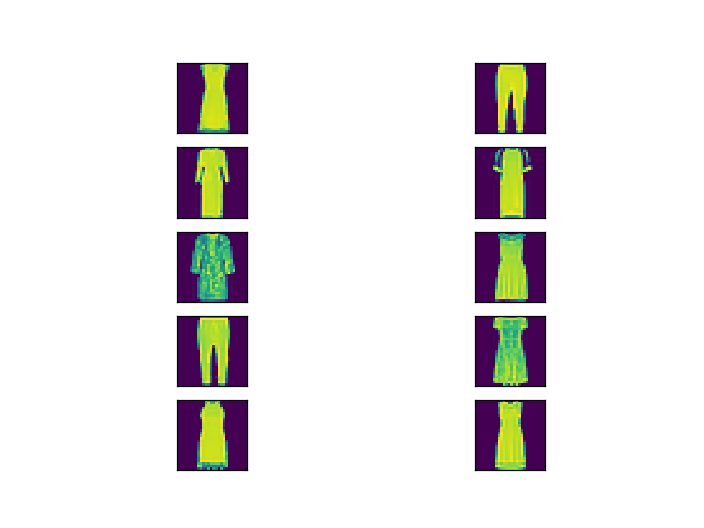

In [30]:
fig = plot_nearest(comp_df.values[499], comp_df.values, data, 10, (5, 2))